In [1]:
import numpy as np
import pandas as pd
from sklearn import tree, ensemble
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

A Random Forest Approach with Bayesian optimisation 
-------------------------------------------------------------------------------

Overview 
-------------

There are a number of steps outlined in this notebook:

- Part 1 - Importing the data set and splitting it into training, validation and testing 
- Part 2 - Fitting a single decision tree
- Part 3 - Using a Random Forest Classifier
- Part 4 - Looking at the most important features
- Part 5 - Hyperparameter selection via Bayesian optimisation
- Part 6 - Testing the final performance

As an invstment manager I am interested in doing dynamic asset allocation. I have a number (in this case 14) equity markets that I can invest in - ranging from the US (the famous S&P 500),the UK (FTSE 100) and numerous European and Asian markets (Hang Seng, ASX 200).

Every month I am looking to see what features are the most likely to point me to the markets that will do better than average over the next month and to those that will do worse than average over th enext month.

I am interested in buying a small (c. 5 or 6) markets per month ('the strategy') and seeing if I outperfrom the average of all the markets ('the benchmark').

For example, if I have $140 to invest then I wish to use the 'best' features to guide me to the best 5 markets to invest $28 per market in ($28x5 = $140) rather than investing $10 in each of the 14 markets (my equally weighted 'benchmark'). 

I will guage how well I do (and how well the model performs) by tracking the perfromance of the strategy vs. the equally weighted benchamrk 

In essence this is a classification problem. If my model correct classifies ('+1') markets that will likely outperfrom next month and ('-1') markets that will likely underperfrom next month then we have a strategy.

Part 1 - Importing and splitting the data set
------------------------------------------------------------

For this excercise I am using a dataset from my job as an investment manager.
 
The dataset consist of 19 different features for each of the 14 markets. These features are calculated once per month and the dataset ranges from 1991 to 2021. Please see the datasheet that is included with this notebook for more details on both the construction of the features, their origin and any pre-processing of the data. We note that for the data:

The training period runs from 1991 - 2010
The validation period runs from 2011 - 2015
The testing period runs from 2016 - 2021

Read in all the data from the data book.
Note that the data has been previously checked for NaNs, winsorized and then Z-scored cross-sectionally.

In [2]:
df_MOM12 = pd.read_excel('Databook.xlsx',sheet_name='MOM12M')
df_MOM6 = pd.read_excel('Databook.xlsx',sheet_name='MOM6M')
df_MOM3 = pd.read_excel('Databook.xlsx',sheet_name='MOM3M')
df_MOM1 = pd.read_excel('Databook.xlsx',sheet_name='MOM1M')
df_SMEY = pd.read_excel('Databook.xlsx',sheet_name='SMEY')
df_EY = pd.read_excel('Databook.xlsx',sheet_name='EY')
df_SMBP = pd.read_excel('Databook.xlsx',sheet_name='SMBP')
df_BP = pd.read_excel('Databook.xlsx',sheet_name='BP')
df_VRP = pd.read_excel('Databook.xlsx',sheet_name='VRP')
df_TSPREAD = pd.read_excel('Databook.xlsx',sheet_name='TSPREAD')
df_VOL = pd.read_excel('Databook.xlsx',sheet_name='VOL')
df_EQSTYLE = pd.read_excel('Databook.xlsx',sheet_name='EQSTYLE')
df_IMPVOL = pd.read_excel('Databook.xlsx',sheet_name='IMPVOL')
df_FED = pd.read_excel('Databook.xlsx',sheet_name='FED')
df_LEI = pd.read_excel('Databook.xlsx',sheet_name='LEI')
df_TOVER = pd.read_excel('Databook.xlsx',sheet_name='TOVER')
df_BETA = pd.read_excel('Databook.xlsx',sheet_name='BETA')
df_ROE = pd.read_excel('Databook.xlsx',sheet_name='ROE')
df_FREELIQ = pd.read_excel('Databook.xlsx',sheet_name='FREELIQ')

df_XSRET = pd.read_excel('Databook.xlsx',sheet_name='XSRETZS')

Further data processing #1
---------------------------------------

1. Remove the 'Date' column from all the dataframes and store it separately
2. Reformat the data so it is in more 'random forest' friendly format
3. Split the data into 'training', 'validation' and 'testing' as defined above
4. Lag the features so that the features at time N are assessed in their ability to forecast returns at time N+1

In [3]:
#
# The purpose of the two routines below is to re-shape the data
#
# Typical feature data read from an Excel spreadsheet looks like a matrix:
#
#            Country1       Country2      Country3      Country4      .... CountryN
# Jan 1991   F_C1_Jan1991   F_C2_Jan1991  F_C3_Jan1991  F_C4_Jan1991       F_CN_Jan1991
# Feb 1991   F_C1_Feb1991   F_C2_Feb1991  F_C3_Feb1991  F_C4_Feb1991       F_CN_Feb1991
# Mar 1991   F_C1_Mar1991   F_C2_Mar1991  F_C3_Mar1991  F_C4_Mar1991       F_CN_Mar1991
# ......
# Mar 2021   F_C1_Mar2021   F_C2_Mar2021  F_C3_Mar2021  F_C4_Mar2021       F_CN_Mar2021
#
# We want it to look like a vector
#
# Jan 1991 F_C1_Jan1991
# Jan 1991 F_C2_Jan1991
# Jan 1991 F_C3_Jan1991
# Jan 1991 F_C4_Jan1991
# Jan 1991 F_C5_Jan1991
# .......
# Jan 1991 F_CN_Jan1991
# Feb 1991 F_C1_Feb1991
# Feb 1991 F_C2_Feb1991
# Feb 1991 F_C3_Feb1991
# Feb 1991 F_C4_Feb1991
# .......
# Mar 2021 F_C1_Mar2021
# .....
# Mar 2021 F_CN_Mar2021
#
#
# In this format its easier to run the Decision Tree or Random Forest algos
#


def reshapeArr(wideArr):
    narrowArr = sum(wideArr.tolist(),[])
    narrowArr = np.array(narrowArr)
    narrowArr = narrowArr.reshape(narrowArr.shape[0],1)
    return narrowArr

def createMatrix(arg1, *argv):
    fullMatrix = reshapeArr(np.array(arg1))
    for arg in argv:
        tmpArr = reshapeArr(np.array(arg))
        fullMatrix = np.concatenate([fullMatrix,tmpArr],axis=1)
    return fullMatrix

In [4]:
df_DATE = pd.to_datetime(df_MOM12['Date'])
df_MOM12 = df_MOM12.drop('Date',axis=1)
df_MOM6 = df_MOM6.drop('Date',axis=1)
df_MOM3 = df_MOM3.drop('Date',axis=1)
df_MOM1 = df_MOM1.drop('Date',axis=1)
df_SMEY = df_SMEY.drop('Date',axis=1)
df_EY = df_EY.drop('Date',axis=1)
df_SMBP = df_SMBP.drop('Date',axis=1)
df_BP = df_BP.drop('Date',axis=1)
df_VRP = df_VRP.drop('Date',axis=1)
df_TSPREAD = df_TSPREAD.drop('Date',axis=1)
df_VOL = df_VOL.drop('Date',axis=1)
df_EQSTYLE = df_EQSTYLE.drop('Date',axis=1)
df_IMPVOL = df_IMPVOL.drop('Date',axis=1)
df_FED = df_FED.drop('Date',axis=1)
df_LEI = df_LEI.drop('Date',axis=1)
df_TOVER = df_TOVER.drop('Date',axis=1)
df_BETA = df_BETA.drop('Date',axis=1)
df_ROE = df_ROE.drop('Date',axis=1)
df_FREELIQ = df_FREELIQ.drop('Date',axis=1)
df_XSRET = df_XSRET.drop('Date',axis=1)

In [5]:
#
# Split the data
#
# Please note that since financial data is autocorrelated we can't use any kind of random splitting. 
# This is covered in the model card.
#
endTrainDate=pd.Timestamp('2011-01-31 00:00:00')

df_MOM12_TRAIN = df_MOM12[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_MOM6_TRAIN = df_MOM6[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_MOM3_TRAIN = df_MOM3[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_MOM1_TRAIN = df_MOM1[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_SMEY_TRAIN = df_SMEY[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_EY_TRAIN = df_EY[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_SMBP_TRAIN = df_SMBP[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_BP_TRAIN = df_BP[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_VRP_TRAIN = df_VRP[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_TSPREAD_TRAIN = df_TSPREAD[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_VOL_TRAIN = df_VOL[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_EQSTYLE_TRAIN = df_EQSTYLE[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_IMPVOL_TRAIN = df_IMPVOL[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_FED_TRAIN = df_FED[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_LEI_TRAIN = df_LEI[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_TOVER_TRAIN = df_TOVER[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_BETA_TRAIN = df_BETA[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_ROE_TRAIN = df_ROE[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_FREELIQ_TRAIN = df_FREELIQ[0:df_DATE[df_DATE==endTrainDate].index[0]]
df_XSRET_TRAIN = df_XSRET[0:df_DATE[df_DATE==endTrainDate].index[0]]

X_train = createMatrix(df_MOM12_TRAIN,df_MOM6_TRAIN,df_MOM3_TRAIN,df_MOM1_TRAIN,df_SMEY_TRAIN,df_EY_TRAIN, \
                    df_SMBP_TRAIN,df_BP_TRAIN,df_VRP_TRAIN,df_TSPREAD_TRAIN,df_VOL_TRAIN,df_EQSTYLE_TRAIN, \
                    df_IMPVOL_TRAIN,df_FED_TRAIN,df_LEI_TRAIN,df_TOVER_TRAIN,df_BETA_TRAIN,df_ROE_TRAIN,df_FREELIQ_TRAIN)
Y_train = createMatrix(df_XSRET_TRAIN)

endValidDate=pd.Timestamp('2016-01-29 00:00:00')
df_MOM12_VALID = df_MOM12[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_MOM6_VALID = df_MOM6[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_MOM3_VALID = df_MOM3[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_MOM1_VALID = df_MOM1[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_SMEY_VALID = df_SMEY[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_EY_VALID = df_EY[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_SMBP_VALID = df_SMBP[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_BP_VALID = df_BP[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_VRP_VALID = df_VRP[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_TSPREAD_VALID = df_TSPREAD[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_VOL_VALID = df_VOL[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_EQSTYLE_VALID = df_EQSTYLE[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_IMPVOL_VALID = df_IMPVOL[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_FED_VALID= df_FED[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_LEI_VALID = df_LEI[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_TOVER_VALID = df_TOVER[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_BETA_VALID = df_BETA[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_ROE_VALID = df_ROE[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_FREELIQ_VALID = df_FREELIQ[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]
df_XSRET_VALID = df_XSRET[df_DATE[df_DATE==endTrainDate].index[0]:df_DATE[df_DATE==endValidDate].index[0]]

X_valid = createMatrix(df_MOM12_VALID,df_MOM6_VALID,df_MOM3_VALID,df_MOM1_VALID,df_SMEY_VALID,df_EY_VALID, \
                    df_SMBP_VALID,df_BP_VALID,df_VRP_VALID,df_TSPREAD_VALID,df_VOL_VALID,df_EQSTYLE_VALID, \
                    df_IMPVOL_VALID,df_FED_VALID,df_LEI_VALID,df_TOVER_VALID,df_BETA_VALID,df_ROE_VALID,df_FREELIQ_VALID)
Y_valid = createMatrix(df_XSRET_VALID)


df_MOM12_TEST = df_MOM12[df_DATE[df_DATE==endValidDate].index[0]:]
df_MOM6_TEST = df_MOM6[df_DATE[df_DATE==endValidDate].index[0]:]
df_MOM3_TEST = df_MOM3[df_DATE[df_DATE==endValidDate].index[0]:]
df_MOM1_TEST = df_MOM1[df_DATE[df_DATE==endValidDate].index[0]:]
df_SMEY_TEST = df_SMEY[df_DATE[df_DATE==endValidDate].index[0]:]
df_EY_TEST = df_EY[df_DATE[df_DATE==endValidDate].index[0]:]
df_SMBP_TEST = df_SMBP[df_DATE[df_DATE==endValidDate].index[0]:]
df_BP_TEST = df_BP[df_DATE[df_DATE==endValidDate].index[0]:]
df_VRP_TEST = df_VRP[df_DATE[df_DATE==endValidDate].index[0]:]
df_TSPREAD_TEST = df_TSPREAD[df_DATE[df_DATE==endValidDate].index[0]:]
df_VOL_TEST = df_VOL[df_DATE[df_DATE==endValidDate].index[0]:]
df_EQSTYLE_TEST = df_EQSTYLE[df_DATE[df_DATE==endValidDate].index[0]:]
df_IMPVOL_TEST = df_IMPVOL[df_DATE[df_DATE==endValidDate].index[0]:]
df_FED_TEST = df_FED[df_DATE[df_DATE==endValidDate].index[0]:]
df_LEI_TEST = df_LEI[df_DATE[df_DATE==endValidDate].index[0]:]
df_TOVER_TEST = df_TOVER[df_DATE[df_DATE==endValidDate].index[0]:]
df_BETA_TEST = df_BETA[df_DATE[df_DATE==endValidDate].index[0]:]
df_ROE_TEST = df_ROE[df_DATE[df_DATE==endValidDate].index[0]:]
df_FREELIQ_TEST = df_FREELIQ[df_DATE[df_DATE==endValidDate].index[0]:]
df_XSRET_TEST = df_XSRET[df_DATE[df_DATE==endValidDate].index[0]:]

X_test = createMatrix(df_MOM12_TEST,df_MOM6_TEST,df_MOM3_TEST,df_MOM1_TEST,df_SMEY_TEST,df_EY_TEST, \
                    df_SMBP_TEST,df_BP_TEST,df_VRP_TEST,df_TSPREAD_TEST,df_VOL_TEST,df_EQSTYLE_TEST, \
                    df_IMPVOL_TEST,df_FED_TEST,df_LEI_TEST,df_TOVER_TEST,df_BETA_TEST,df_ROE_TEST,df_FREELIQ_TEST)
Y_test = createMatrix(df_XSRET_TEST)


1. Lag the features by one month since we expect the features for month N to forecast the excess returns for month N+1.
2. Replace the relative excess returns with a '1' or a '-1' depending on whether they are above 0 or below 0

Please note that we are using a z-score excess return feature so that any excess return greater than the average should have a positive excess return (> average) and any excess return below the average should have a negative excess return.

In [6]:
X_end = X_train.shape[0]
X_train = X_train[0:X_end-1,:]
Y_train = Y_train[1:Y_train.shape[0],:]

X_end = X_valid.shape[0]
X_valid = X_valid[0:X_end-1,:]
Y_valid = Y_valid[1:Y_valid.shape[0],:]

X_end = X_test.shape[0]
X_test = X_test[0:X_end-1,:]
Y_test = Y_test[1:Y_test.shape[0],:]

In [7]:
YMax = 0.0

for i in range(Y_train.shape[0]):
    if (Y_train[i] >= YMax):
        Y_train[i] = 1
    else:
        Y_train[i] = -1             

for i in range(Y_valid.shape[0]):
    if (Y_valid[i] >= YMax):
        Y_valid[i] = 1
    else:
        Y_valid[i] = -1       

for i in range(Y_test.shape[0]):
    if (Y_test[i] >= YMax):
        Y_test[i] = 1
    else:
        Y_test[i] = -1       


Part 2: Fit a Single Decision Tree
-----------------------------------------------

Fit a decision trees with different depths up to `max_depth = 10`. Select the best depth, this will be useful to compare to the random forest approach next

In [8]:
max_depth = 10
bestscore = 0
for i in range(max_depth):
    clf = tree.DecisionTreeClassifier(max_depth=i+1, random_state=0)
    clf.fit(X_train,Y_train)
    trainscore=clf.score(X_train,Y_train)
    valscore=clf.score(X_valid,Y_valid)    
    print( 'Depth:', i+1, 'Train Score:', trainscore, 'Validation Score:', valscore)

    if valscore>bestscore:
        bestscore=valscore
        bestdepth=i+1
print(bestdepth, bestscore)

Depth: 1 Train Score: 0.5111640369157487 Validation Score: 0.49463647199046484
Depth: 2 Train Score: 0.5415302173265852 Validation Score: 0.5077473182359953
Depth: 3 Train Score: 0.5602857993450432 Validation Score: 0.5470798569725864
Depth: 4 Train Score: 0.5718963977374218 Validation Score: 0.5089392133492253
Depth: 5 Train Score: 0.5894611491515332 Validation Score: 0.5482717520858165
Depth: 6 Train Score: 0.6132777612384638 Validation Score: 0.5256257449344458
Depth: 7 Train Score: 0.6323310509080083 Validation Score: 0.531585220500596
Depth: 8 Train Score: 0.6445370646025603 Validation Score: 0.5268176400476758
Depth: 9 Train Score: 0.6615064007144984 Validation Score: 0.5375446960667462
Depth: 10 Train Score: 0.6790711521286097 Validation Score: 0.5351609058402861
5 0.5482717520858165


In [ ]:
The best solution from the decision tree is a depth of 5 and a validation score= 0.548.
How does this compare to the random forest approach?

Part 3: Random Forest
---------------------------------

Build a random forest model using some hyperparameters that you think are 'good enough' to get a decent fit.

In [9]:
rf_clf = ensemble.RandomForestClassifier(n_estimators=50, max_features=4, max_depth=4,random_state=0)
rf_clf.fit(X_train, np.ravel(Y_train))

RandomForestClassifier(max_depth=4, max_features=4, n_estimators=50,
                       random_state=0)

In [10]:
print ( 'Random Forest guess training ',rf_clf.score(X_train, Y_train))
print ( 'Random Forest guess validation ',rf_clf.score(X_valid, Y_valid))

Random Forest guess training  0.6484072640666865
Random Forest guess validation  0.5244338498212158


Since we don't let the random forest do whatever it wants our best guess yields a not-too-bad validation results = 0.524.
Before we try and improve on this what are the most important features in the training+validation set?

Part 4: Most Important Feature Selection
----------------------------------------------------------

We identify the most important features using two different methods:
- Impurity metric approaches
- Permutation Importances 

and we examine the most important features over the training and validation sets

In [11]:
X_trainvalid = np.concatenate((X_train,X_valid),axis=0)
Y_trainvalid = np.concatenate((Y_train,Y_valid),axis=0)
rf_clf = ensemble.RandomForestClassifier(n_estimators=50, max_features=4, max_depth=4,random_state=0)
rf_clf.fit(X_trainvalid, np.ravel(Y_trainvalid))

RandomForestClassifier(max_depth=4, max_features=4, n_estimators=50,
                       random_state=0)

In [12]:
feature_importances = rf_clf.feature_importances_
sorted_idx = feature_importances.argsort()

In [13]:
feature_names = ['MOM12','MOM6','MOM3','MOM1','SMEY','EY','SMBP','BP','VRP','TSPREAD','VOL','EQSTYLE','IMPVOL', \
                 'FED','LEI','TOVER','BETA','ROE','FREELIQ']
feature_names = np.array(feature_names)

In [14]:
def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()


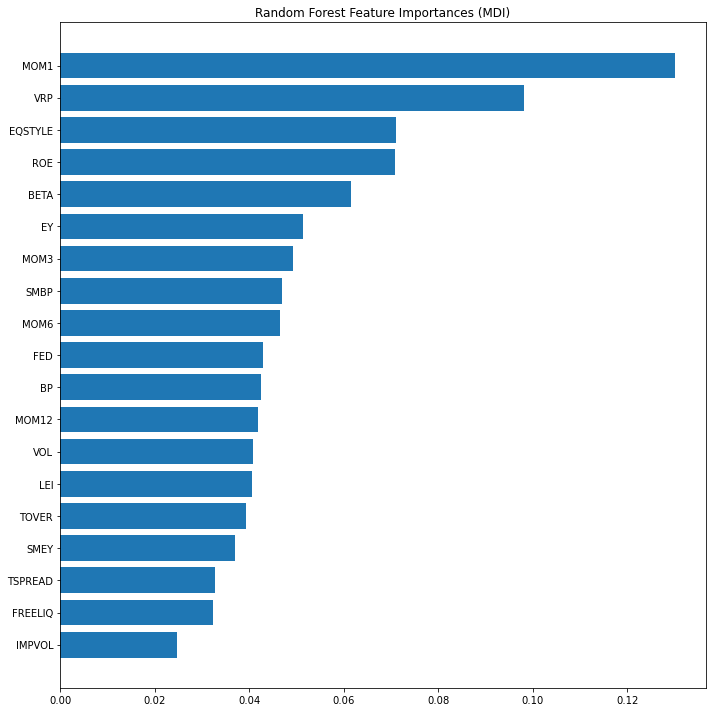

In [15]:
# impurity metric based approach on training

plot_impurity_metric_features( feature_importances, sorted_idx, feature_names)

We can use the permutation importance to measure the feature importances on both the training and validation sets. 

In [16]:
# permutation method on the training data


result = permutation_importance(estimator=rf_clf, X=X_trainvalid, y=Y_trainvalid, n_repeats=10, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

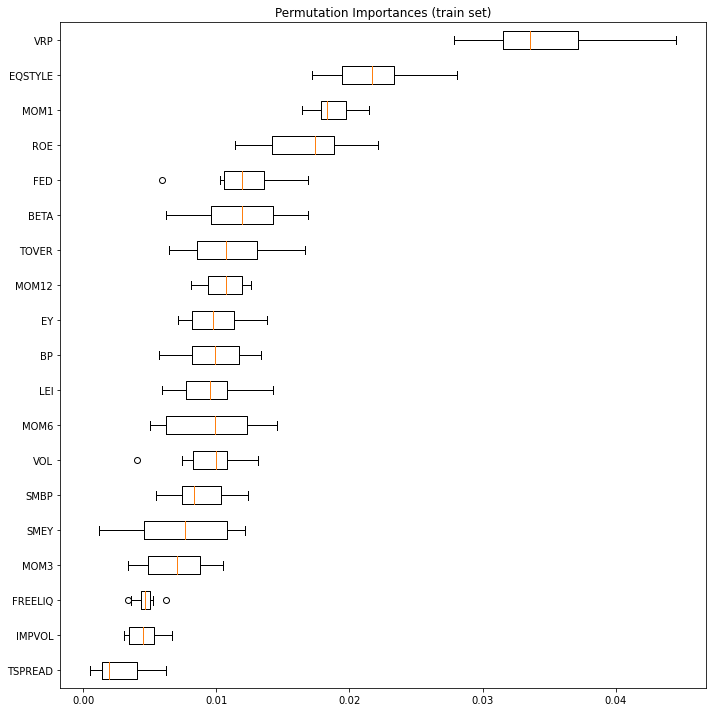

In [17]:

def plot_perm_importance(result, sorted_idx, feature_names):

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
    )
    ax.set_title("Permutation Importances (train set)")
    fig.tight_layout()
    plt.show()
    
plot_perm_importance(result, sorted_idx, feature_names)


In [ ]:
In both the permutation case and theimpurity metric case the most important features are the same - VRP, MOM1 and EQSTYLE.
It is encouraging to see such consistency across te differnt methodologies

Aside - Hyperparameter selection via  Grid Search
-----------------------------------------------------------------------

I started to do a hyperparamter search using grid search but I gave up after 5 hours! 

In [609]:
#Random Forest
from sklearn.model_selection import GridSearchCV
# Define the hyperparameter configuration space

rf_params = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70 ,80, 90, 100],
    "max_features": [1,2,3,4,5,6,7,8,9,10],
    'max_depth': [3,4,5,6,7,8,9,10],
    "min_samples_split":[2,3,4,5,6,7,8,9,10,11],
    "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10,11]
}
clf = ensemble.RandomForestClassifier(random_state=0)
grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
grid.fit(X_trainval, np.ravel(Y_trainval))
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

KeyboardInterrupt: 

Part 5 - Hyperparameter selection via  Bayesian Optimisation
---------------------------------------------------------------------------------------

I picked the most important hyperparameters of a random forest for the bayesioan approach and ran it 20 times.

In [18]:
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': Integer(10,100),
    "max_features":Integer(1,10),  
    'max_depth': Integer(3,10),
    "min_samples_split":Integer(2,11),
    "min_samples_leaf":Integer(1,11),
    "criterion":['gini','entropy']
}
clf = ensemble.RandomForestClassifier(random_state=0)
Bayes = BayesSearchCV(clf, rf_params,cv=3,n_iter=20, n_jobs=-1,scoring='accuracy')
Bayes.fit(X_trainvalid, np.ravel(Y_trainvalid))
Bayes.score(X_valid, Y_valid)
print(Bayes.best_params_)
bclf = Bayes.best_estimator_
print("Accuracy:"+ str(Bayes.best_score_))

OrderedDict([('criterion', 'entropy'), ('max_depth', 8), ('max_features', 9), ('min_samples_leaf', 1), ('min_samples_split', 11), ('n_estimators', 62)])
Accuracy:0.5266784097484597


In [21]:
best_clf = ensemble.RandomForestClassifier(n_estimators=62, max_features=8, max_depth=8, min_samples_split=11, \
                                         min_samples_leaf=1, criterion='entropy', random_state=0)
best_clf.fit(X_trainvalid, np.ravel(Y_trainvalid))

print ( f'Random forest (post Bayes) validation set',best_clf.score(X_valid, Y_valid))

Random forest (post Bayes) validation set 0.8092967818831943


In [ ]:
We note that usiong Bayesian optimisation to pick the optimal parameters using the training and validation sets 
results in a much better result for the validation set.

This result is far superior to the one achieved above by 'guessing' the correct values.

Step 6 - Perfromance on the test set
-----------------------------------------------------

Given the good perfromance on the validation set, how does the model perfrom on the test set?

In [22]:
print ( f'Random forest (post Bayes) test set ',best_clf.score(X_test, Y_test))

Random forest (post Bayes) test set  0.52894438138479


Now calculate the permutation importance on the test set. 

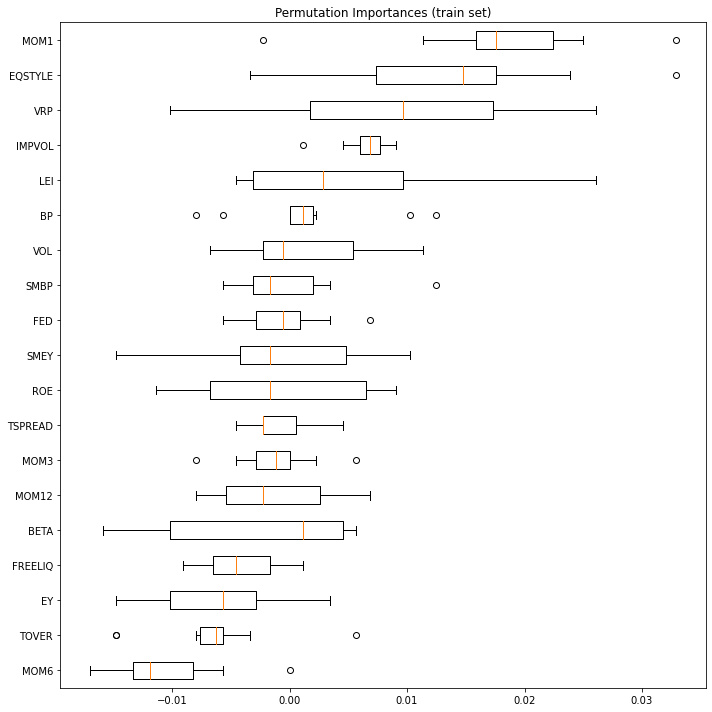

In [37]:
result = permutation_importance(best_clf, X_test, Y_test, n_repeats=10, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

plot_perm_importance(result, sorted_idx, feature_names)

Summary
--------------

We note a number of things about the test results:

1. Using Bayesian optimisation to arrive at the optimal parameters worked ok. Applying these hyperparameters to the validation dataset yielded a much better validation set accusacy than our simple guess at the start.

2. While the accuracy in the test set (53%) is less than in the validation set (80%) this is still a good result. Why? 
Unlike many of the ML examples we had throughout the course, accuarcy rates of 90% - 100% are unheard of in financial data since it is extremely noisy and subject to business cycles - see the model card for more details. An accuracy rate of 53% is actually a very good starting point for a real-world model.

3. The most important features - MOM1, VRP and EQSTYLE - are consistently in the Top 5 throughout the training, validation and testing datasets indicating that these are very important features. See the model card for an idea of how identifying these 3 features forms the basis of the investment strategy.

Overall this is a pretty good result and I look forward to extending and expanding the model to see if the accuracy rates can be increased a touch (say c. 60%). Random forests are pretty robust to noise and I am keen to see if the more sophisticated approached (ANN, CNN) do as good a job. 